In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

In [183]:
# from google.colab import drive
# drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x263ab497670>)

In [5]:
test_df = pd.read_table('ratings_test.txt')
train_df = pd.read_table('ratings_train.txt')
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 전처리

In [6]:
# 중복이 있는지 확인
train_df['document'].nunique(), train_df['label'].nunique()

(146182, 2)

In [7]:
# 중복 샘플 제거
train_df.drop_duplicates(subset=['document'], inplace=True) 
train_df.shape

(146183, 3)

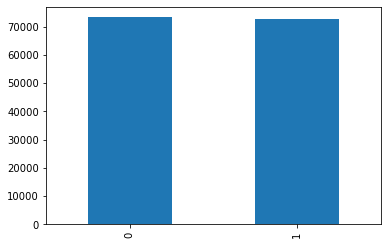

In [8]:
# 긍정,부정 레이블 값의 분포
train_df['label'].value_counts().plot(kind = 'bar');

In [9]:
train_df['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [10]:
train_df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [11]:
train_df.loc[train_df.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [12]:
# Null 값이 존재하는 행 제거
train_df = train_df.dropna(how = 'any') 
train_df.isnull().sum()

id          0
document    0
label       0
dtype: int64

- 테스트 데이터 셋에도 마찬가지로 적용

In [13]:
test_df['document'].nunique(), test_df['label'].nunique()

(49157, 2)

In [14]:
# Null 값이 존재하는 행 제거
test_df = test_df.dropna(how = 'any') 

In [15]:
test_df['document'].nunique(), test_df['label'].nunique()

(49157, 2)

In [16]:
test_df.drop_duplicates(subset=['document'], inplace=True) 
test_df.shape

(49157, 3)

### 텍스트 전처리

In [17]:
# 한글과 공백을 제외하고 모두 제거
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [18]:
train_df['document'].replace('', np.nan, inplace=True)
print(train_df.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [19]:
train_df.loc[train_df.document.isnull()][:5]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [20]:
train_df = train_df.dropna(how = 'any')
print(len(train_df))

145791


- 테스트 데이터에도 적용

In [21]:
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df['document'].replace('', np.nan, inplace=True)
test_df = test_df.dropna(how = 'any')

In [22]:
print(len(test_df))

48995


In [25]:
train_df.to_csv('../00.data/naverMovieReview/train_df.tsv',sep='\t')
test_df.to_csv('../00.data/naverMovieReview/test_df.tsv',sep='\t')

### 토큰화

In [26]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을']

In [27]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [28]:
from tqdm.notebook import tqdm
X_train = []
for sentence in tqdm(train_df['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 stem => 어근으로 추정
    temp_X = ' '.join([word for word in temp_X if not word in stopwords]) # 불용어 제거
    X_train.append(temp_X)

In [29]:
print(X_train[:3])

['아 더빙 진짜 짜증나다 목소리', '흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍다 않다', '너 무재 밓었 다그 래서 보다 추천 다']


In [30]:
X_test = []
for sentence in tqdm(test_df['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 stem => 어근으로 추정
    temp_X = ' '.join([word for word in temp_X if not word in stopwords]) # 불용어 제거
    X_test.append(temp_X)

In [31]:
print(X_test[:3])

['굳다 ㅋ', '뭐 야 평점 나쁘다 않다 점 짜다 리 더 더욱 아니다', '지루하다 않다 완전 막장 임 돈 주다 보기 에는']


In [32]:
y_train = train_df.label.values
y_test = test_df.label.values

### CountVectorizer, LogisticRegression

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [34]:
cvector = CountVectorizer()
cvector.fit(X_train)
X_train_cvect = cvector.transform(X_train)
X_test_cvect = cvector.transform(X_test)

In [35]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_cvect,y_train)
pred = lr_clf.predict(X_test_cvect)
accuracy_score(y_test,pred)

0.8261659352995203

### 실제 테스트

In [167]:
review1 = '진짜 개노잼이다.. 1편이랑 같은 감독맞나?러닝타임도 길어서 개지루함 ㄹㅇ'
review2 = '이런 사랑영화가 다시 나올 수 있을까?'

In [168]:
import re
review1 = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",review1)
review2 = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",review2)

In [169]:
morphs = okt.morphs(review1, stem=True) # 토큰화 stem => 어근으로 추정
review = ' '.join([word for word in morphs if not word in stopwords]) # 불용어 제거
review

'진짜 개 노잼 이다 편이 랑 같다 감독 맞다 러닝 타임 기다 개 지루함 ㄹㅇ'

In [170]:
review_cvect = cvector.transform([review])

In [171]:
pred = lr_clf.predict(review_cvect)
pred[0]

0

In [173]:
morphs = okt.morphs(review2, stem=True) # 토큰화 stem => 어근으로 추정
review = ' '.join([word for word in morphs if not word in stopwords]) # 불용어 제거
review_cvect = cvector.transform([review])
pred = lr_clf.predict(review_cvect)
pred[0]

1

In [175]:
reviews = ['진짜 개노잼이다.. 1편이랑 같은 감독맞나?러닝타임도 길어서 개지루함 ㄹㅇ','이런 사랑영화가 다시 나올 수 있을까?']

In [181]:
review_list = []
for review in reviews:
    review = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",review)
    morphs = okt.morphs(review, stem=True)
    tmp =' '.join([word for word in morphs if not word in stopwords])
    review_list.append(tmp)

In [182]:
review_cvect = cvector.transform(review_list)
preds = lr_clf.predict(review_cvect)
preds[0],preds[1]

(0, 1)

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
def parapipe(params, pipeline, cv=3):
    grid_pipe = GridSearchCV(pipeline, param_grid=params,cv=cv,
                            scoring='accuracy',verbose=1,n_jobs=-1)
    grid_pipe.fit(X_train,y_train)
    pred = grid_pipe.predict(X_test)
    acc = accuracy_score(y_test,pred)
    print(grid_pipe.best_params_,grid_pipe.best_score_)
    print(f'grid_pipe acc : {acc:.4f}')

In [37]:
params = {
    'count_vect__ngram_range':[(1,1),(1,2)],
    'count_vect__max_df':[0.8,0.9],
    'count_vect__min_df':[1,2],
}
pipeline = Pipeline([
    ('count_vect',CountVectorizer()),
    ('lr_clf',LogisticRegression())
])

parapipe(params, pipeline)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.6min finished
{'count_vect__max_df': 0.8, 'count_vect__min_df': 1, 'count_vect__ngram_range': (1, 2)} 0.8411973304250605
grid_pipe acc : 0.8466
